<a href="https://colab.research.google.com/github/Jayden-Nyamiaka/Machine-Learning-and-Data-Mining/blob/main/nyamiaka_jayden_prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

# Part A: Data Setup

In [ ]:
# Loads COVID Data

df = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set4/data/COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")
df.rename(columns={"Unnamed: 0":"bias", "cdc_case_earliest_dt ":"cdc_case_earliest_dt"}, inplace=True)
df["bias"] = 1

In [ ]:
# PREPROCESSES DATASET

# Helper function to find the percent that a value appears in a column
def appearancePercent(dataframe, column, value):
  return (dataframe[column]==value).sum() / len(df) * 100

# Helper function to remove any rows where the value at the indicated 
# column equals one of the values provided in the values list
def removeUnavailable(dataframe, column, values):
  total_percent = 0
  for value in values:
    total_percent += appearancePercent(dataframe, column, value)
  print("Dropped Rows with", column, "=", values, ":", total_percent, "%")
  for value in values:
    dataframe.drop(dataframe.loc[df[column]==value].index, inplace=True)
  print()

# Helper function to normalize a feature column using mean and stddev
def normalize_column(dataframe, column):
  dataframe[column] = (dataframe[column] - dataframe[column].mean()) / dataframe[column].std() 

# Print Number of Data Points before Preprocessing
print("Number of Data Points Before Preprocessing:", len(df), "points")
print("Number of Features Before Preprocessing (Not including death_yn or bias):", len(df.columns) - 2, "features")
print()

# Finds and drop any duplicates in the dataset, if there are any
df.drop_duplicates(inplace=True)

# Finds and drops the columns with unavailable values (the three dates)
print("Percent of Unavailable Values per Input Variable: ")
print(df.isna().sum()/len(df)*100)
df.dropna(axis=1,inplace=True)
print()

# Drops rows with missing and unknown death info
removeUnavailable(df, "death_yn", ["Unknown", "Missing"])

# Drops racial identity column (shouldn't be considered for moral reasons)
df.drop("race_ethnicity_combined", axis=1, inplace=True)

# Transforms string dates for cdc_case_earliest_dt into numerical time stamps
def time_str_to_numerical(time_str):
  return datetime.timestamp(datetime.strptime(time_str, "%Y/%m/%d"))
df["cdc_case_earliest_dt"] = df["cdc_case_earliest_dt"].apply(time_str_to_numerical)

# Finds and removes rows with Unknown, Missing, Other, or NA sex values
# Note: There are so little points without sex set that we can just remove them
removeUnavailable(df, "sex", ["Unknown", "Missing", "Other", "NA"])

# Sets current status and sex to boolean (1, 0) values
df["current_status"].replace({"Laboratory-confirmed case": 1, "Probable Case": 0}, inplace=True)
df["sex"].replace({"Male": 1, "Female": 0}, inplace=True)

# Uses one hot encoding for hosp_yn, icu_yn, and medcond_yn 
df["hosp_yn"].replace({"No": "no_hosp", "Unknown": "hosp_unknown", "Missing": "hosp_unknown", "Yes": "hosp"}, inplace=True)
df["icu_yn"].replace({"No": "no_icu", "Unknown": "icu_unknown", "Missing": "icu_unknown", "Yes": "icu"}, inplace=True)
df["medcond_yn"].replace({"No": "no_medcond", "Unknown": "medcond_unknown", "Missing": "medcond_unknown", "Yes": "medcond"}, inplace=True)
df = df.join(pd.get_dummies(df["hosp_yn"]))
df = df.join(pd.get_dummies(df["icu_yn"]))
df = df.join(pd.get_dummies(df["medcond_yn"]))
df.drop(["hosp_yn", "icu_yn", "medcond_yn", "hosp_unknown", "icu_unknown", "medcond_unknown"], axis=1, inplace=True)

# Finds and removes rows with Missing or NA age_group values
# Note: There are so little points without age group set that we can just remove them
removeUnavailable(df, "age_group", ["Missing", "NA"])

# Enumerates age_group values starting at 0
df["age_group"].replace({"0 - 9 Years": 0, 
                         "10 - 19 Years": 1,
                         "20 - 29 Years": 2,
                         "30 - 39 Years": 3,
                         "40 - 49 Years": 4,
                         "50 - 59 Years": 5,
                         "60 - 69 Years": 6,
                         "70 - 79 Years": 7,
                         "80+ Years": 8}, inplace=True)

# Sets death info to boolean (1, 0) values
df["death_yn"].replace({"Yes": 1, "No": 0}, inplace=True)

# Moves death_yn labels to the last column
death_labels = df["death_yn"]
df.drop("death_yn", axis=1, inplace=True)
df["death_yn"] = death_labels

# Normalizes cdc_case_earliest_dt and age_group features using mean and stddev
for column in df.columns:
  if column == "bias" or column == "death_yn":
    continue
  normalize_column(df, column)
print("Normalized All Columns of Data")
print()

print("Number of Data Points After Preprocessing:", len(df), "points")
print("Number of Features After Preprocessing (Not including death_yn or bias):", len(df.columns) - 2, "features")
display(df.head(12))


Number of Data Points Before Preprocessing: 800000 points
Number of Features Before Preprocessing (Not including death_yn or bias): 11 features

Percent of Unavailable Values per Input Variable: 
bias                        0.000000
cdc_case_earliest_dt        0.000000
cdc_report_dt               5.696436
pos_spec_dt                48.831920
onset_dt                   53.871555
current_status              0.000000
sex                         0.000000
age_group                   0.000000
race_ethnicity_combined     0.000000
hosp_yn                     0.000000
icu_yn                      0.000000
death_yn                    0.000000
medcond_yn                  0.000000
dtype: float64

Dropped Rows with death_yn = ['Unknown', 'Missing'] : 61.67776358281605 %

Dropped Rows with sex = ['Unknown', 'Missing', 'Other', 'NA'] : 1.7555048942445133 %

Dropped Rows with age_group = ['Missing', 'NA'] : 0.0 %

Normalized All Columns of Data

Number of Data Points After Preprocessing: 217195 points


,bias,cdc_case_earliest_dt,current_status,sex,age_group,hosp,no_hosp,icu,no_icu,medcond,no_medcond,death_yn
0,1,-1.396417,0.458860,1.030078,0.711241,-0.244811,0.768307,-0.073181,-0.297453,-0.2786,-0.352003,0
1,1,1.950307,-2.179306,1.030078,1.643255,-0.244811,-1.301557,-0.073181,-0.297453,-0.2786,-0.352003,0
5,1,0.638103,0.458860,-0.970796,-1.152787,-0.244811,0.768307,-0.073181,-0.297453,-0.2786,-0.352003,0
6,1,-1.191761,0.458860,1.030078,-1.152787,-0.244811,0.768307,-0.073181,-0.297453,-0.2786,-0.352003,0
8,1,-1.007169,0.458860,-0.970796,-0.686780,-0.244811,0.768307,-0.073181,-0.297453,-0.2786,-0.352003,0
9,1,0.465550,0.458860,1.030078,-1.152787,-0.244811,-1.301557,-0.073181,-0.297453,-0.2786,-0.352003,0
12,1,-0.509575,0.458860,-0.970796,0.711241,-0.244811,0.768307,-0.073181,-0.297453,-0.2786,-0.352003,0
13,1,0.682244,0.458860,1.030078,0.245234,-0.244811,-1.301557,-0.073181,-0.297453,-0.2786,-0.352003,0
14,1,-0.999144,0.458860,1.030078,-0.220773,-0.244811,-1.301557,-0.073181,-0.297453,-0.2786,-0.352003,0
15,1,0.822694,0.458860,-0.970796,0.711241,-0.244811,-1.301557,-0.073181,-0.297453,-0.2786,-0.352003,0


In [ ]:
# Split training and test data 70:30
split_index_7030 = int(len(df) * 0.7)
num_features = len(df.columns) - 1
training_data = df.iloc[:split_index_7030, :]
test_data = df.iloc[split_index_7030:, :]

train_X = torch.tensor(training_data.drop("death_yn", axis=1).values.astype(np.float32))
train_y = torch.tensor(training_data["death_yn"].values.astype(np.int_))

test_X = torch.tensor(test_data.drop("death_yn", axis=1).values.astype(np.float32))
test_y = torch.tensor(test_data["death_yn"].values.astype(np.int_))

# Make datasets and dataloaders
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 


# Part B: Linear Neural Network

## Model Setup

In [ ]:
# Makes your model, optmizer, and loss function here.
size = 5
learning_rate = 1e-3
model = nn.Sequential(
    nn.Linear(num_features, size),
    nn.Dropout(0.5),
    nn.Linear(size, 2),
    nn.Softmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

##Training and Testing Helper Functions

In [ ]:
# Trains the model, printing the loss at every epoch as a decimal
def train_model(model, epochs, train_loader, optimizer, loss_fn):
  # Some layers, such as Dropout, behave differently during training
  epochs = 8

  model.train()

  for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(train_loader):
          # Erase accumulated gradients
          optimizer.zero_grad()

          # Forward pass
          output = model(data)

          # Calculate loss
          loss = loss_fn(output, target)

          # Backward pass
          loss.backward()
          
          # Weight update
          optimizer.step()

      # Track loss each epoch
      print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))


# Tests the model, printing the average loss and accuracy
def test_model(model, test_loader, loss_fn):
  # Putting layers like Dropout into evaluation mode
  model.eval()

  test_loss = 0
  correct = 0

  # Turning off automatic differentiation
  with torch.no_grad():
      for data, target in test_loader:
          output = model(data)
          test_loss += loss_fn(output, target).item()  # Sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
        (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Training Loop

In [ ]:
epochs = 8
train_model(model, epochs, train_loader, optimizer, loss_fn)

Train Epoch: 1  Loss: 0.3133
Train Epoch: 2  Loss: 0.3133
Train Epoch: 3  Loss: 0.3142
Train Epoch: 4  Loss: 0.3134
Train Epoch: 5  Loss: 0.3133
Train Epoch: 6  Loss: 0.3133
Train Epoch: 7  Loss: 0.3133
Train Epoch: 8  Loss: 0.3137


## Testing Loop

In [ ]:
test_model(model, test_loader, loss_fn)

Test set: Average loss: 0.0107, Accuracy: 63252/65159 (97.0733)


## Weight Matrix Visualization

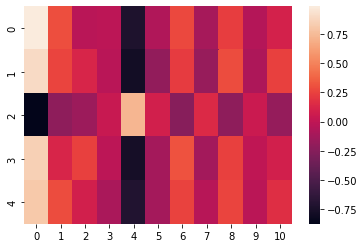

In [ ]:
weights = model.state_dict()['0.weight']

sns.heatmap(weights)

# Part C: 2-Layer Linear Model

In [ ]:
# Trains a 2-layer model on our dataset

# Makes the model, optmizer, and loss function
size = 5
hidden_layer_size = 8
learning_rate = 1e-3
model = nn.Sequential(
    nn.Linear(num_features, hidden_layer_size),
    nn.Dropout(0.5),
    nn.Linear(hidden_layer_size, size),
    nn.Dropout(0.5),
    nn.Linear(size, 2),
    nn.Softmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Trains the model
epochs = 8
train_model(model, epochs, train_loader, optimizer, loss_fn)

# Tests the model
test_model(model, test_loader, loss_fn)

# Visualizes the weight matrix
weights = model.state_dict()['0.weight']
sns.heatmap(weights)

NameError: ignored